In [158]:
import pandas as pd
from tqdm import tqdm
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

tqdm.pandas()

In [159]:
# TODO: consider link citation in a message as a fwd even if fwd_from is None
# TODO: keep reference to fwds even when unkown (as done by Kilian in analysisK.ipynb) 
def get_fwd_name(id, original_df, links_df):
    res = original_df[original_df.peer_id == id].chat
    if len(res) < 1:
        res = links_df[links_df.id == id].chat_name
        if len(res) < 1:
            return None
        else:
            return res.values[0]
    else:
        return res.values[0]

In [162]:
messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')
messages['messageDateTime'] = messages['messageDate'].astype('datetime64[ns]')
messages['year_month'] = messages['messageDateTime'].dt.strftime('%Y_%m')
messages['chat'] = messages.chat.progress_apply(lambda x: x.replace('https://t.me/', ''))

/var/folders/fb/v6scng3j5lbcmnb3mjn82zhr0000gn/T/ipykernel_79551/518116159.py:1: DtypeWarning:

Columns (24,25,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.

100%|██████████| 1623145/1623145 [00:00<00:00, 2278149.02it/s]


In [163]:
links = pd.read_csv('../../../data/telegram/cleaned_channels_with_id.csv')

In [164]:
original = messages[['peer_id', 'chat']]

messages['fwd_from_name'] = messages.fwd_from.progress_apply(lambda x: get_fwd_name(x, original, links))

100%|██████████| 1623145/1623145 [14:23<00:00, 1879.00it/s]


In [165]:
only_forwards = messages[~messages['fwd_from_name'].isna()]

In [166]:
messages.fwd_from_name.describe()

count     42281
unique       47
top       mig41
freq       4255
Name: fwd_from_name, dtype: object

In [236]:
test = only_forwards.groupby(['chat', 'fwd_from_name', 'peer_id', 'fwd_from', 'year_month']).size().reset_index().rename(columns={0:'count'})
test['value'] = test['count']
test

,chat,fwd_from_name,peer_id,fwd_from,year_month,count,value
0,Medvedeva_Olesya,stranaua,1134053707,1.092414e+09,2019_10,5,5
1,Medvedeva_Olesya,stranaua,1134053707,1.092414e+09,2019_11,22,22
2,Medvedeva_Olesya,stranaua,1134053707,1.092414e+09,2019_12,31,31
3,Medvedeva_Olesya,stranaua,1134053707,1.092414e+09,2020_01,31,31
4,Medvedeva_Olesya,stranaua,1134053707,1.092414e+09,2020_02,25,25
...,...,...,...,...,...,...,...
5021,warjournaltg,wargonzo,1144404150,1.135021e+09,2023_05,1,1
5022,warjournaltg,wargonzo,1144404150,1.135021e+09,2024_02,1,1
5023,warjournaltg,xronikabpla,1144404150,1.602838e+09,2022_09,1,1
5024,warjournaltg,xronikabpla,1144404150,1.602838e+09,2022_11,2,2


MovieWriter ffmpeg unavailable; using Pillow instead.


85
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


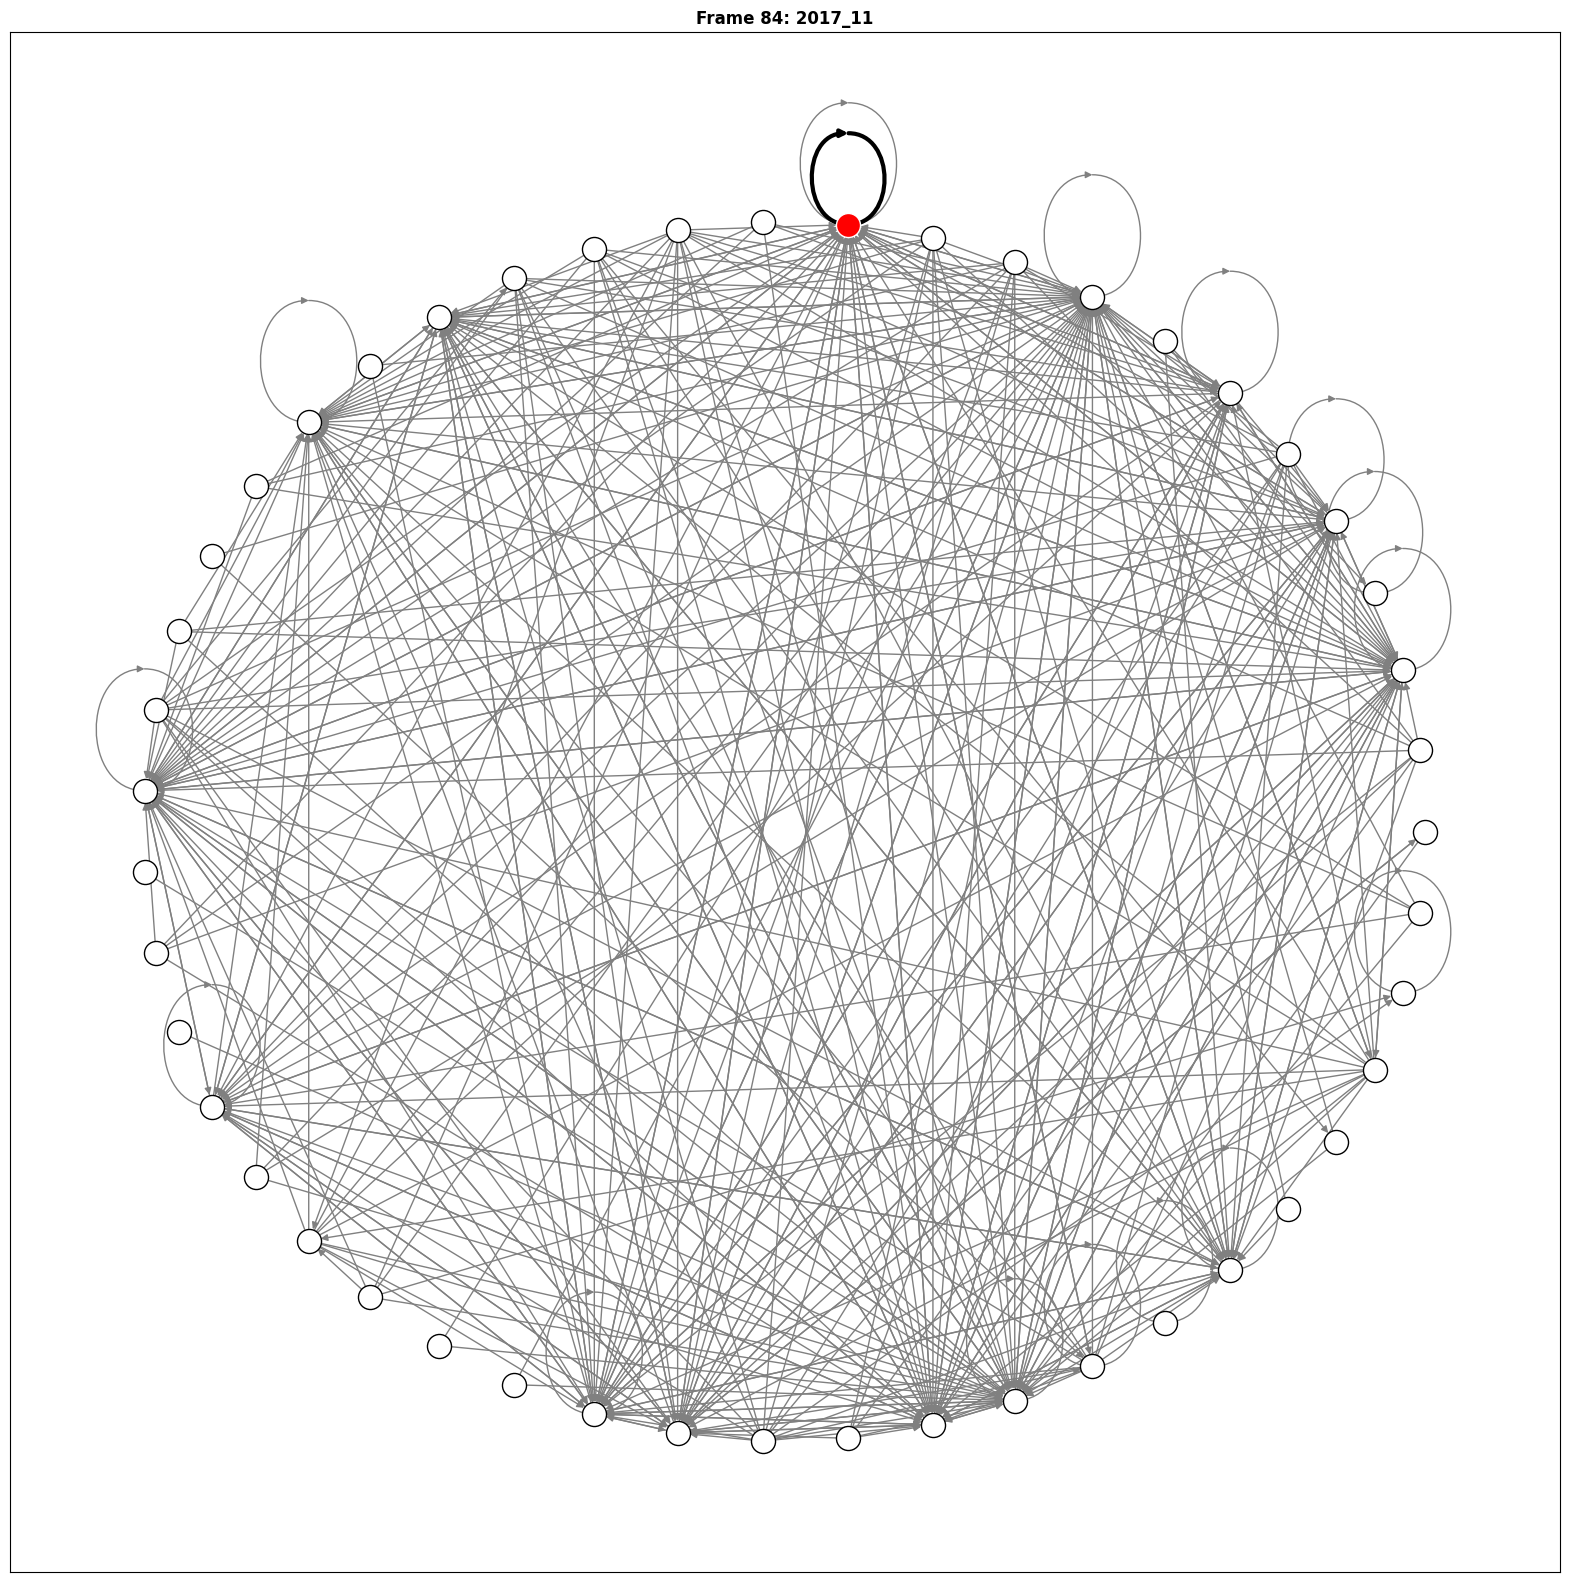

In [174]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

# Build plot
fig, ax = plt.subplots(figsize=(20,20))

G = nx.DiGraph()

nodes_source = list(test.fwd_from_name.values)
nodes_destination = list(test.chat.values)
nodes = list(set([*nodes_source, *nodes_destination]))
G.add_nodes_from(nodes)

edges = list(test[['fwd_from_name', 'chat']].values)
G.add_edges_from(edges)

pos = nx.circular_layout(G)

def draw_year_graph(num, dates, df):
    ax.clear()
    print(num)
    
    temp = df[df.year_month == dates[num]]
    nodes_source = list(temp.fwd_from_name.values)
    nodes_destination = list(temp.chat.values)
    nodes_to_highlight = list(set([*nodes_source, *nodes_destination]))
    edges_to_highlight = list(temp[['fwd_from_name', 'chat']].values)

    # Background nodes
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")
    null_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=set(G.nodes()) - set(nodes_to_highlight), node_color="white",  ax=ax)
    null_nodes.set_edgecolor("black")

    # Query nodes
    query_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes_to_highlight, node_color='red', ax=ax)
    query_nodes.set_edgecolor("white")
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path,path)),  font_color="white", ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_to_highlight, width=[3]*len(edges_to_highlight), ax=ax)

    ax.set_title(f"Frame {num}: {dates[num]}", fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    

dates = test.year_month.unique()
nb_frames = len(dates)
print(nb_frames)
anim = matplotlib.animation.FuncAnimation(fig, draw_year_graph, frames=nb_frames, fargs=(dates, test), interval=1000, repeat=True)
anim.save('test.png')
plt.show()

In [257]:
# Define network object
# G = nx.DiGraph()
G = nx.from_pandas_edgelist(
    test[['chat', 'fwd_from_name', 'value']],
    source='fwd_from_name',
    target='chat',
    edge_attr='value',
    create_using=nx.Graph()
)

In [258]:
#Add Nodes
# nodes_source = list(test.fwd_from_name.values)
# nodes_destination = list(test.chat.values)
# nodes = list(set([*nodes_source, *nodes_destination]))
# G.add_nodes_from(nodes)

In [259]:
#Add Edges
# edges = list(test[['fwd_from_name', 'chat']].values)
# G.add_edges_from(edges)

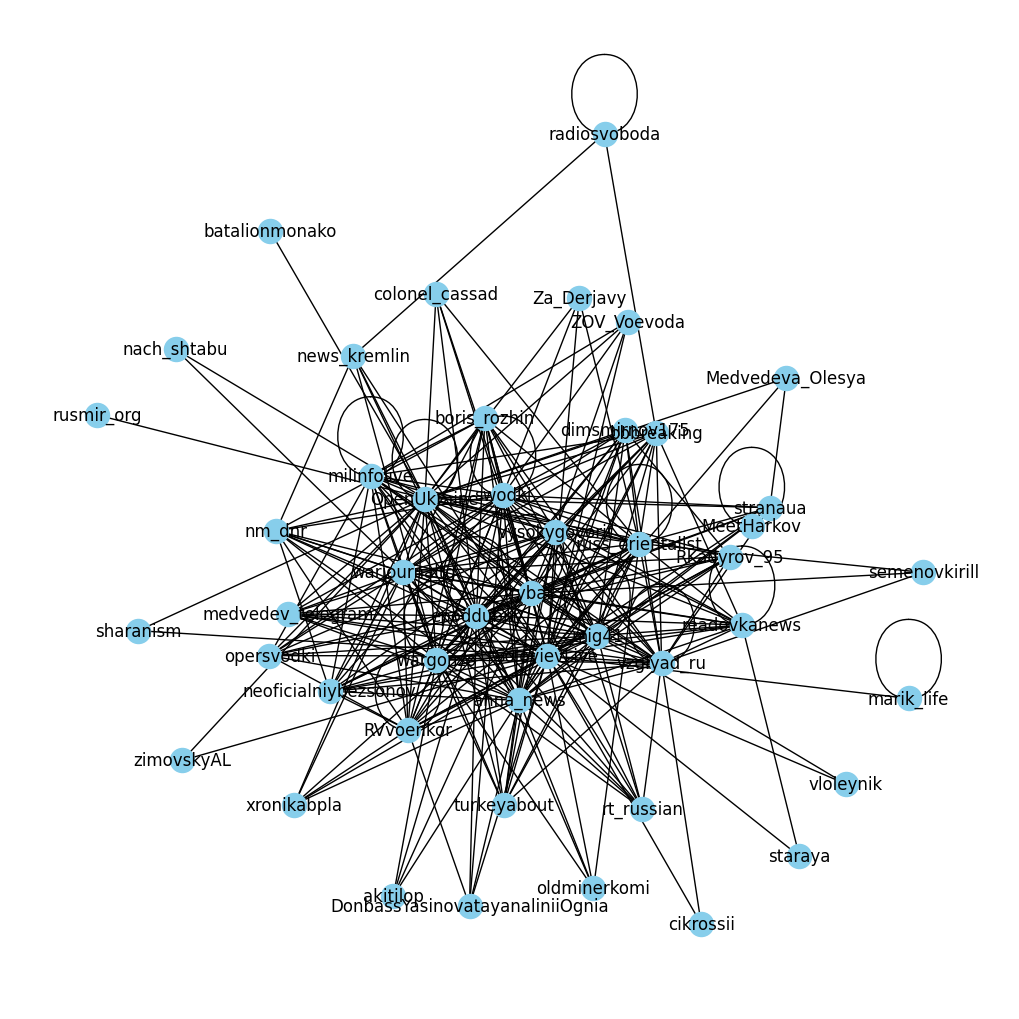

In [260]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', arrowsize=10, arrows=True, edge_cmap=plt.cm.Blues)

net = Network(notebook=True, width='100wh', height='100vh', bgcolor='#222222', font_color='white')
net.from_nx(G)

degree_nodes = dict(G.degree)
nx.set_node_attributes(G, degree_nodes, 'size')

net.toggle_physics(False)
net.save_graph('test_other.html')

<Axes: >

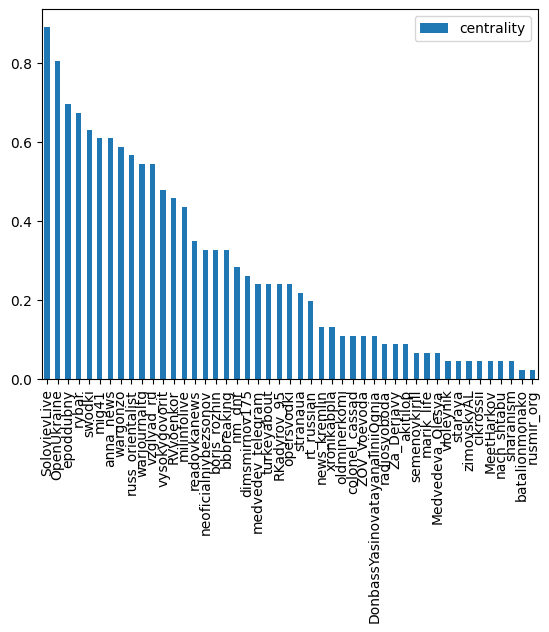

In [261]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False).plot(kind='bar')

<Axes: >

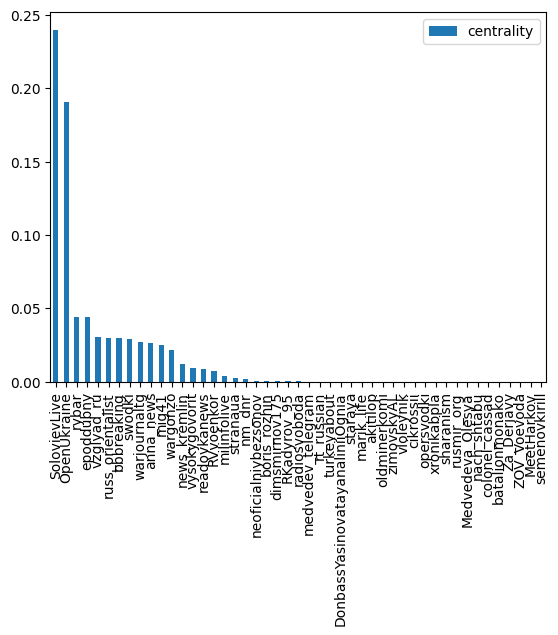

In [262]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False).plot(kind='bar')

<Axes: >

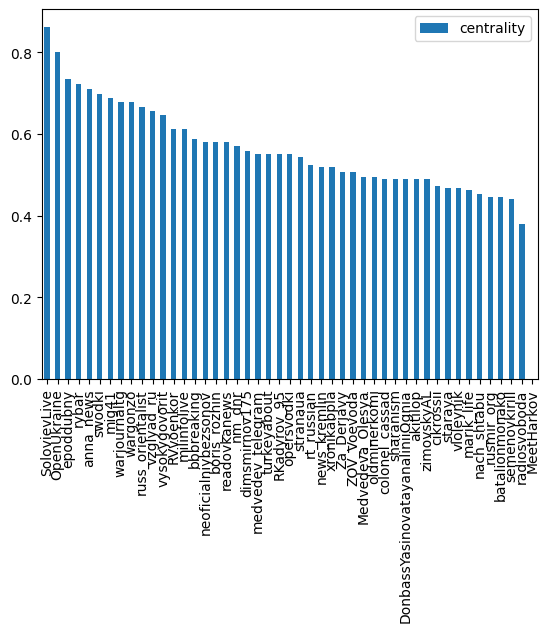

In [264]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False).plot(kind='bar')

In [265]:
import community as community_louvain

communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')

net = Network(notebook=True, width='100wh', height='75vh', bgcolor='#222222', font_color='white', select_menu=True, filter_menu=True)
net.from_nx(G)
net.toggle_physics(False)
net.show_buttons(filter_=['physics'])
net.save_graph('with_communities.html')